In [8]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import seaborn as sns

sns.set_style('whitegrid')

In [9]:
class Pendulum:
    def __init__(self, th, thdot, normalize_angle=True):
        self.initial = [th, thdot]
        self.x = np.array([[self.angle_normalize(th) if normalize_angle else th], [thdot]], dtype=np.float32)
        self.last_u = 0
        self.sim_info = None
        self.A = np.array([[1.00049, 0.0100016], [0.098016, 1.00049]])
        self.B = np.array([[0.01], [0.0005]])
        self.normalize_angle = normalize_angle

    def step(self, kt):
        u = self._calc_control(kt)
        self.x_next = self.A @ self.x + self.B @ u
        if self.normalize_angle:
            self.x_next[0] = self.angle_normalize(self.x_next[0])
        self.last_u = u
        self.x = self.x_next
        return self.x_next

    def _calc_control(self, kt):
        state = self.x.copy().reshape(2, 1)
        u = kt.dot(state).reshape(1, 1)
        return u

    
    def _calc_value(self, p0):
        x = np.array(deepcopy(self.sim_info))[:, :2].reshape(-1, 2, 1)
        return (x.transpose(0, 2, 1) @ p0 @ x).flatten()
    
    def angle_normalize(self, x):
        return (((x + np.pi) % (2 * np.pi)) - np.pi)
    

    def run(self, k_all: np.ndarray):
        """Run a simulation with the given control input. `u = Kt * x`, and com

        Args:
            kt: Matrix of control gains of shape (num_steps, 1, 2)

        """
        if k_all is None:
            k_all = np.zeros((100, 1, 2))
        num_steps = k_all.shape[0]
        self.sim_info = []
        for i in tqdm(range(num_steps), desc="Steping through the simulation"):
            self.sim_info.append(
                [
                    self.x[0].item(),
                    self.x[1].item(),
                    self._calc_control(k_all[i]).item(),
                ]
            )  # current state, control input
            _ = self.step(k_all[i])

        return self.sim_info


    def plot_sim_info(self, states=None, p0=None, plot_value=False, plot_control=False, custom_title="", xlim=None, ylim=None):
        """Plot theta vs thdot graph

        Args:
            states (_type_, optional): _description_. Defaults to None.
        """
        if states is None:
            states = np.array(self.sim_info)
        states = np.array(states)
        plt.plot(states[:, 0], label="Theta")
        plt.plot(states[:, 1], label="Theta_dot")
        if plot_control:
            plt.plot(states[:, 2], label="Control Input")
        if plot_value:
            assert p0 is not None, "p0 is needed for calculating value function."
            plt.plot(self._calc_value(p0), label="Value", linestyle="--")
        if xlim is not None:
            low, high, step = xlim
            plt.xlim(low, high)
            # plt.xticks(np.arange(low, high, step))
        if ylim is not None:
            low, high, step = ylim
            plt.ylim(low, high)
            # plt.yticks(np.arange(low, high, step))
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        # plot legend outside the plot
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.title(f"Initial State: [{self.initial[0]}, {self.initial[1]}] {custom_title}")
        plt.show()


Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 94205.23it/s]


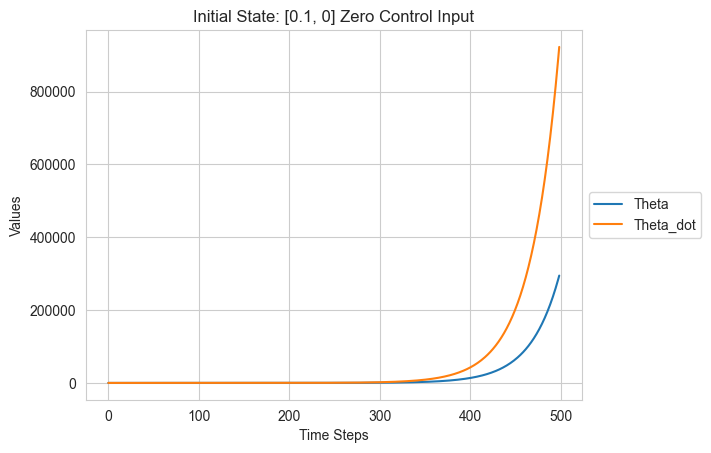

In [10]:
p = Pendulum(0.1, 0, normalize_angle=False)
states = p.run(k_all=np.zeros((499, 1, 2)))
p.plot_sim_info(custom_title="Zero Control Input")

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 121796.89it/s]


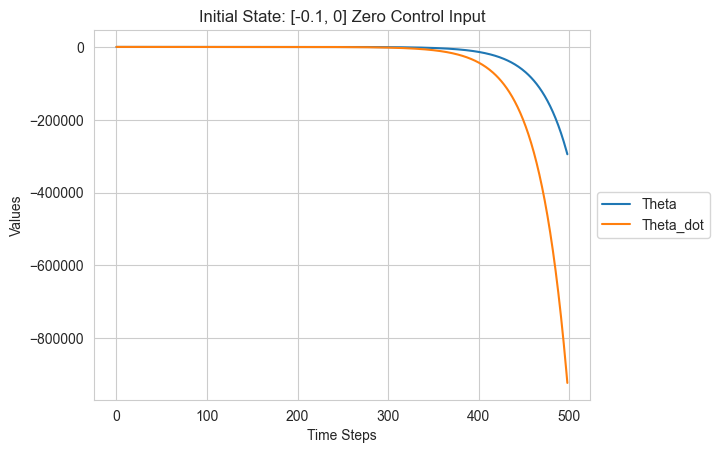

In [11]:
p = Pendulum(-0.1, 0, normalize_angle=False)
states = p.run(k_all=np.zeros((499, 1, 2)))
p.plot_sim_info(custom_title="Zero Control Input")

In the below cases, the angle is normalised. So theta always stays between [-π, π], this is to clearly understand and show the moment of pendulum.

When the pendulum is starting from theta = 0.1 and thetadot=0.0, the pendulum seems to have increase in both angle(theta) and angular velocity(thetadot) until 'π' and after that as it is against gravity, thetadot seems to decrease and since it is in opposite direction, theta goes to negative values i.e (-π -> o), and it goes on. Even when the theta = -0.1 and thetadot=0.0, same thing happens but in the opposite direction

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 66170.02it/s]


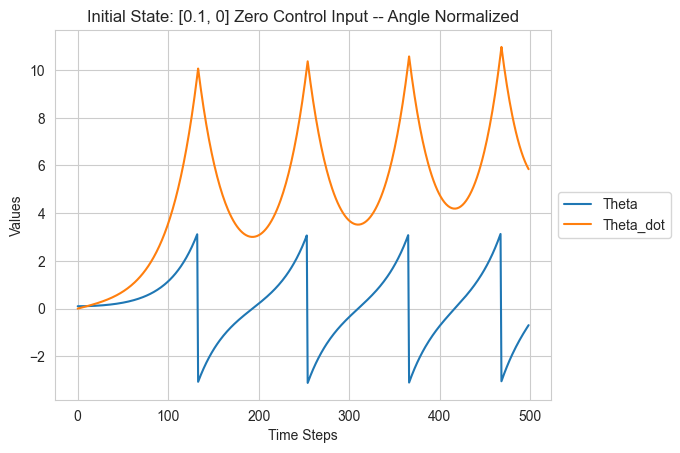

In [12]:
p = Pendulum(0.1, 0, normalize_angle=True)
states = p.run(k_all=np.zeros((499, 1, 2)))
p.plot_sim_info(custom_title="Zero Control Input -- Angle Normalized")

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 90938.85it/s]


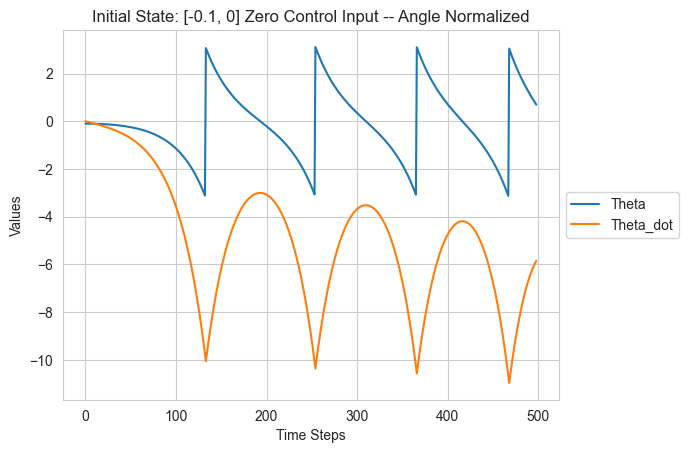

In [13]:
p = Pendulum(-0.1, 0, normalize_angle=True)
states = p.run(k_all=np.zeros((499, 1, 2)))
p.plot_sim_info(custom_title="Zero Control Input -- Angle Normalized")

As expected, the pendulum **does not stay near the top.**

With the given Dynamics model implemented, the pendulum is behaving as expected. When the pendulum is starting from theta = 0.1 and thetadot=0.0, the pendulum seems to have increase in angle(theta) and angular velocity(thetadot).

Even in the case where theta = -0.1 and thetadot=0.0, both angle(theta) and angular velocity(thetadot) are increasing but motion is in reverse direction as expected.

In [14]:
def lqr(A, B, Q, R, Qf, N):
    P = np.zeros((N+1, 2, 2))

    P[N] = Qf
    for t in range(N, 0, -1):
        P[t - 1] = (
            Q
            + A.transpose().dot(P[t]).dot(A)
            - A.transpose()
            .dot(P[t])
            .dot(B)
            .dot(np.linalg.inv(R + B.transpose().dot(P[t]).dot(B)))
            .dot(B.transpose())
            .dot(P[t])
            .dot(A)
        )

    K = np.zeros((N, 1, 2))
    
    for t in range(0, N):
        K[t] = -1 * (
            np.linalg.inv(R + B.transpose().dot(P[t + 1]).dot(B))
            .dot(B.transpose())
            .dot(P[t + 1])
            .dot(A)
        )


    return K, P

##### Running for alpha = 0.001 #####


Steping through the simulation:   0%|          | 0/499 [00:00<?, ?it/s]

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 109070.70it/s]


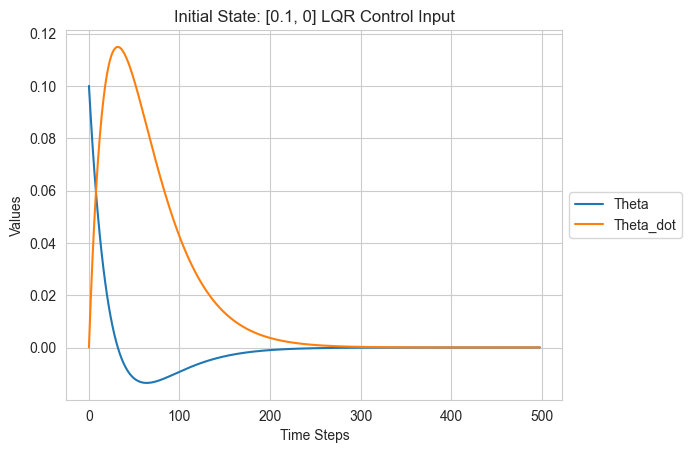

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 157519.21it/s]


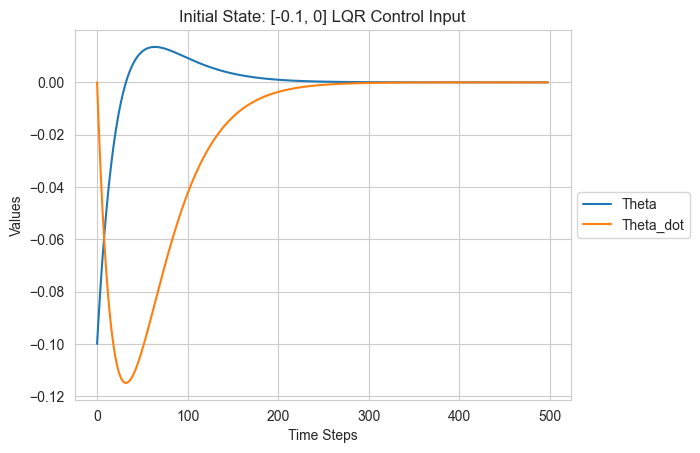

##### Running for alpha = 0.1 #####


Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 162282.52it/s]


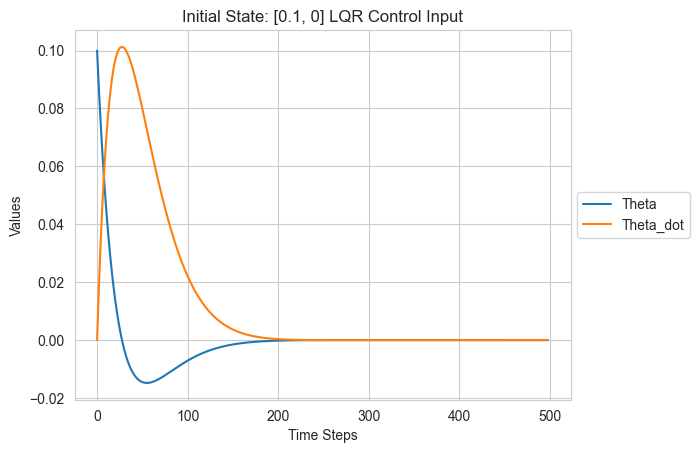

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 128940.22it/s]


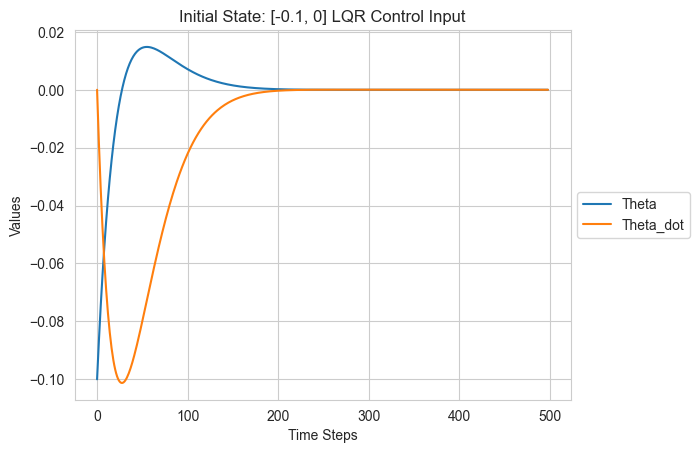

##### Running for alpha = 100 #####


Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 106576.93it/s]


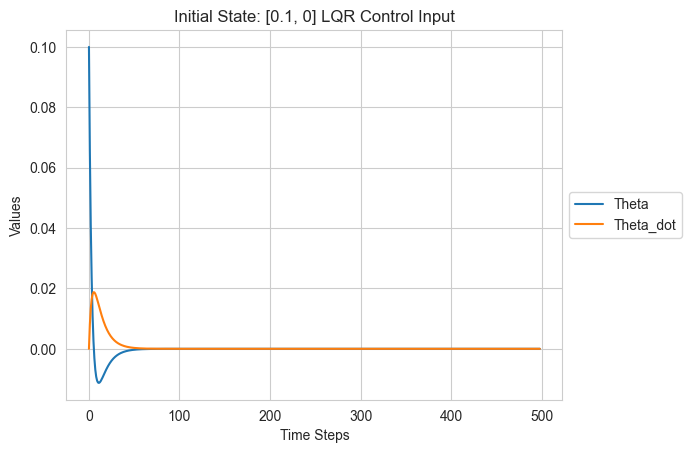

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 130361.74it/s]


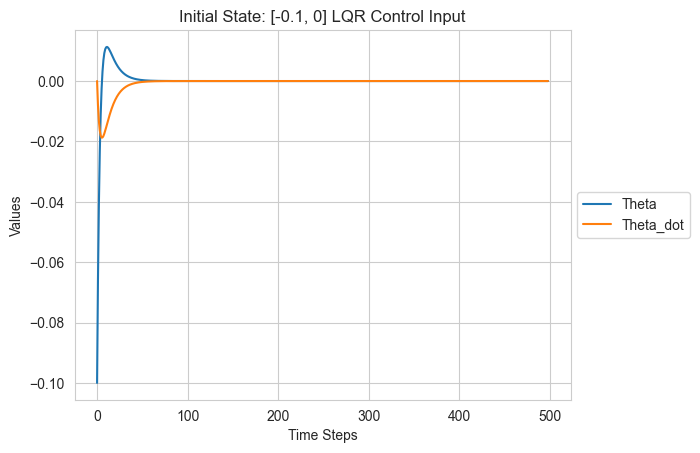

In [15]:
timesteps = 499
alpha = [0.001, 0.1, 100]

for i in range(3):
    print(f"##### Running for alpha = {alpha[i]} #####")
    Q = alpha[i] * np.identity(n=2)

    R = 0.1

    A = np.array([[1.00049, 0.0100016], [0.098016, 1.00049]])
    B = np.array([[0.01], [0.0005]])

    k_all, p_all = lqr(A, B, Q, R, Q, timesteps)


    p = Pendulum(0.1, 0, normalize_angle=False)
    states = p.run(k_all=k_all)
    p.plot_sim_info(p0=p_all[0], plot_value=False, custom_title="LQR Control Input")
    
    p = Pendulum(-0.1, 0, normalize_angle=False)
    states = p.run(k_all=k_all)
    p.plot_sim_info(p0=p_all[0], plot_value=False, custom_title="LQR Control Input")

- Here, we simulate the pendulum using given dynamics but passing the pre calculated lqr control input applied for each specific time step.
- This clearly shows the pendulum's angle and velocity values converging to zero at all cases.
- With varying alpha, we specify how much to focus on the **error in position** (theta here), thus with increase in alpha, we can expect to see the pendulum's angle converging to zero faster, and vice versa, which is clearly shown in the plots above

##### Running for alpha = 0.1 #####


Steping through the simulation:   0%|          | 0/499 [00:00<?, ?it/s]

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 90954.66it/s]


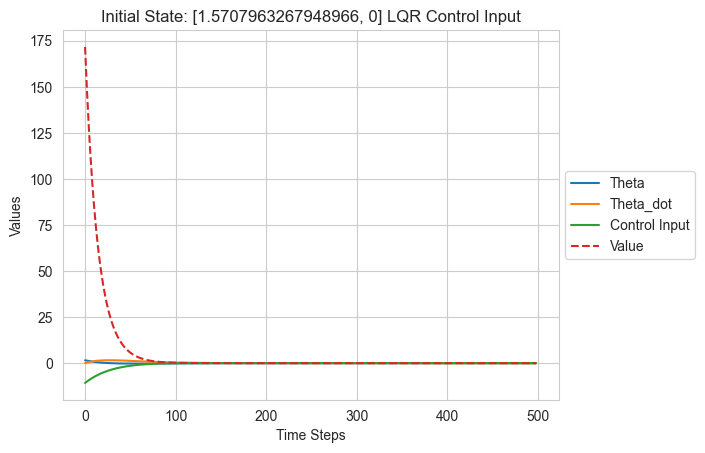

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 113933.46it/s]


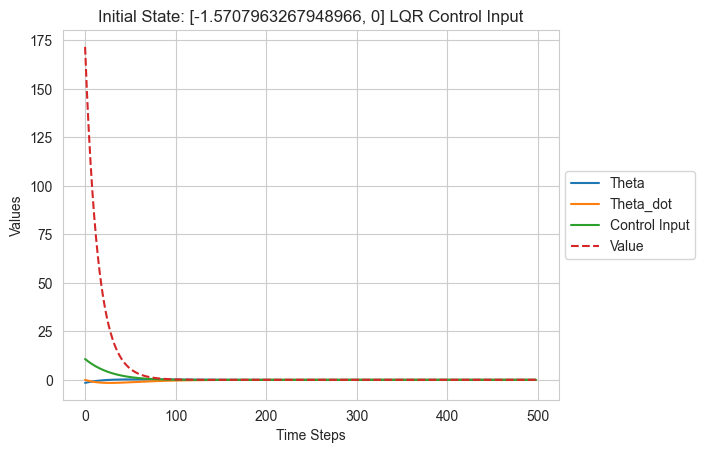

In [16]:
timesteps = 499
alpha = 0.1

print(f"##### Running for alpha = {alpha} #####")
Q = alpha * np.identity(n=2)

R = 0.1

A = np.array([[1.00049, 0.0100016], [0.098016, 1.00049]])
B = np.array([[0.01], [0.0005]])

k_all, p_all = lqr(A, B, Q, R, Q, timesteps)


p = Pendulum(np.pi/2, 0, normalize_angle=False)
states = p.run(k_all=k_all)
p.plot_sim_info(p0=p_all[0], plot_value=True, plot_control=True, custom_title="LQR Control Input")
p = Pendulum(-np.pi/2, 0, normalize_angle=False)
states = p.run(k_all=k_all)
p.plot_sim_info(p0=p_all[0], plot_value=True, plot_control=True, custom_title="LQR Control Input")

- We plotted the value function above to show how the value function changes with each state, and how the value function converges to zero as the state converges to zero. 
- This is expected as the value function is the cost to go from that state to the goal state, and as the state converges to the goal state, the cost also goes down and converges to zero.
- The above 2 plots plotted at leaving the pendulum at np.pi/2 and -np.pi/2 respectively, show the same plot for the value function, but different control inputs which were applied wrt to the direction
- Below is the axis limited to see the shift closely

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 67241.46it/s]


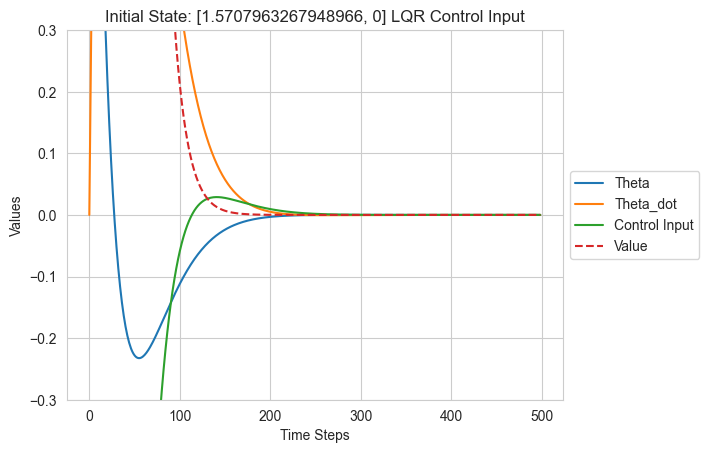

In [17]:
p = Pendulum(np.pi/2, 0, normalize_angle=False)
states = p.run(k_all=k_all)
p.plot_sim_info(p0=p_all[0], plot_value=True, plot_control=True, custom_title="LQR Control Input", ylim=(-0.3, 0.3, 0.001))

These are the initial conditions and its corresponding plots

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 93477.34it/s]


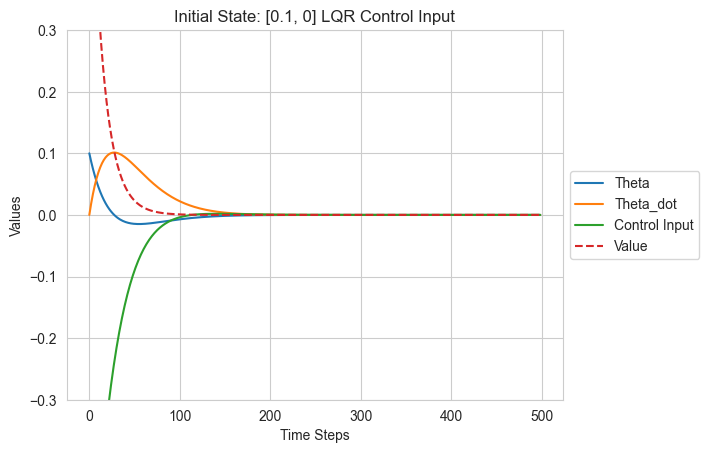

Steping through the simulation: 100%|██████████| 499/499 [00:00<00:00, 171063.15it/s]


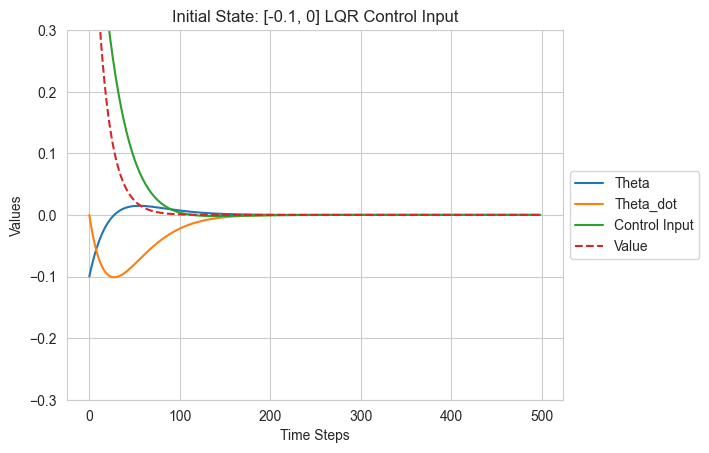

In [18]:
p = Pendulum(0.1, 0, normalize_angle=False)
states = p.run(k_all=k_all)
p.plot_sim_info(p0=p_all[0], plot_value=True, plot_control=True, custom_title="LQR Control Input", ylim=(-0.3, 0.3, 0.001))
p = Pendulum(-0.1, 0, normalize_angle=False)
states = p.run(k_all=k_all)
p.plot_sim_info(p0=p_all[0], plot_value=True, plot_control=True, custom_title="LQR Control Input", ylim=(-0.3, 0.3, 0.001))